In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools
import math_functions as mf

from scipy.optimize import root
from scipy.integrate import odeint


from sacred.observers import MongoObserver
from sacred import Experiment

In [2]:
'''''
To run Omniboard:

    -m 127.0.0.1:27017:Skeleton_model

    http://localhost:9000/sacred

'''''

"''\nTo run Omniboard:\n\n    -m 127.0.0.1:27017:Skeleton_model\n\n    http://localhost:9000/sacred\n\n"

In [32]:
###### constants ######

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 1
k_b6f = 10
k_PSI = 1
PQ_tot = 1
PC_tot = 1

###### Experimental parameters - steady state ######

I_low = 0.0001        # lowest light intensity for P X I curve
I_high = 50       # highest light intensity for P X I curve
I_steps = 10000     # number of steps between I_low and I_high


###### Experimental parameters - dynamic ######

nb_periods = 30             # number of periods for dynamic simulation
points_per_period = 100    # number of points per period


###### Experimental parameters - frequency response ######

f_low = -3          # lowest frequency for dynamic simulation (10**f_low Hz)
f_high = 3          # highest frequency for dynamic simulation (10**f_high Hz)
f_steps = 30        # number of steps between f_low and f_high (log scale)
phase_threshold = 10  # threshold for phase (in degrees)







In [33]:
def steady_state(I, x0):
    def equations(x):
        
        C_PQ = x[0]
        C_PC_plus = x[1]
        
        C_PQH2 = PQ_tot - C_PQ
        C_PC = PC_tot - C_PC_plus
        
        dC_PQ_dt =  k_b6f * C_PC_plus * C_PQH2 - (I * sigma_PSII * k_p * C_PQ)/(k_p * C_PQ + k_fh)
        dPC_plus_dt = k_PSI * I * sigma_PSI * C_PC - 2 * k_b6f * C_PC_plus * C_PQH2
        
        return [dC_PQ_dt, dPC_plus_dt]
    
    sol = root(equations, x0)
    return sol.x

def run_steady_state():
    x0 = [PQ_tot/2, PC_tot/2]
    I = np.linspace(I_low, I_high, I_steps)
    C_PQ = np.zeros_like(I)
    C_PC_plus = np.zeros_like(I)
    
    for i, intensity in enumerate(I):
        C_PQ[i], C_PC_plus[i] = steady_state(intensity, x0)
    
    return I, C_PQ, C_PC_plus

def dynamic(x, t, offset, amplitude, frequency):
    
    I = offset + amplitude * np.sin(2 * np.pi * frequency * t)
    
    C_PQ = x[0]
    C_PC_plus = x[1]
    
    C_PQH2 = PQ_tot - C_PQ
    C_PC = PC_tot - C_PC_plus
    
    dC_PQ_dt =  k_b6f * C_PC_plus * C_PQH2 - (I * sigma_PSII * k_p * C_PQ)/(k_p * C_PQ + k_fh)
    dPC_plus_dt = k_PSI * I * sigma_PSI * C_PC - 2 * k_b6f * C_PC_plus * C_PQH2
    
    return [dC_PQ_dt, dPC_plus_dt]

def run_dynamic(offset, amplitude, frequency):
    t = np.linspace(0, nb_periods/frequency, nb_periods * points_per_period)
    x0 = steady_state(offset, [PQ_tot/2, PC_tot/2])
    x = odeint(dynamic, x0, t, args=(offset, amplitude, frequency))
    C_PQ = x[:, 0]
    C_PC_plus = x[:, 1]
    I = offset + amplitude * np.sin(2 * np.pi * frequency * t)
    
    return t, I, C_PQ, C_PC_plus

def get_dependent_variables(C_PQ, C_PC_plus, I):

    C_PQH2 = PQ_tot - C_PQ
    C_PC = PC_tot - C_PC_plus
    
    v_b6f = k_b6f * C_PC_plus * C_PQH2
    v_PSI = k_PSI * I * sigma_PSI * C_PC
    v_PSII = I * sigma_PSII * k_p * C_PQ/(k_p * C_PQ + k_fh)
    
    return C_PQH2, C_PC, v_b6f, v_PSI, v_PSII

def on_pick(event):
    leg = event.artist
    isVisible = leg.get_visible()

    graphs[leg].set_visible(not isVisible)
    leg.set_visible(not isVisible)

    fig.canvas.draw()
    
def run_frequency_response(offset, amplitude):
    x0 = steady_state(offset, [PQ_tot/2, PC_tot/2])
    frequencies = np.logspace(f_low, f_high, f_steps)
    bode_times = []
    bode_PQ = []
    bode_PC_plus = []
    for frequency in frequencies:
        t, I, C_PQ, C_PC_plus = run_dynamic(offset, amplitude, frequency)
        bode_times.append(t)
        bode_PQ.append(C_PQ)
        bode_PC_plus.append(C_PC_plus)
        
    return bode_times, bode_PQ, bode_PC_plus, frequencies

def get_harmonics(input_freq, F, A, P, nb_harmonics, pic_search_window):
    index_fund = tools.closest_index(F, input_freq)
    harmonics = {'f_input': input_freq}
    for i in range(nb_harmonics):
        index = index_fund*(i+1)
        search_window = [index - pic_search_window, index + pic_search_window]
        index_max = np.argmax(A[search_window[0]:search_window[1]]) + search_window[0]
        harmonics[f'A_{i}'] = A[index_max]
        harmonics[f'f_{i}'] = F[index_max]
        harmonics[f'P_{i}'] = P[index_max]

    return pd.DataFrame(harmonics, index=[0])
        
    


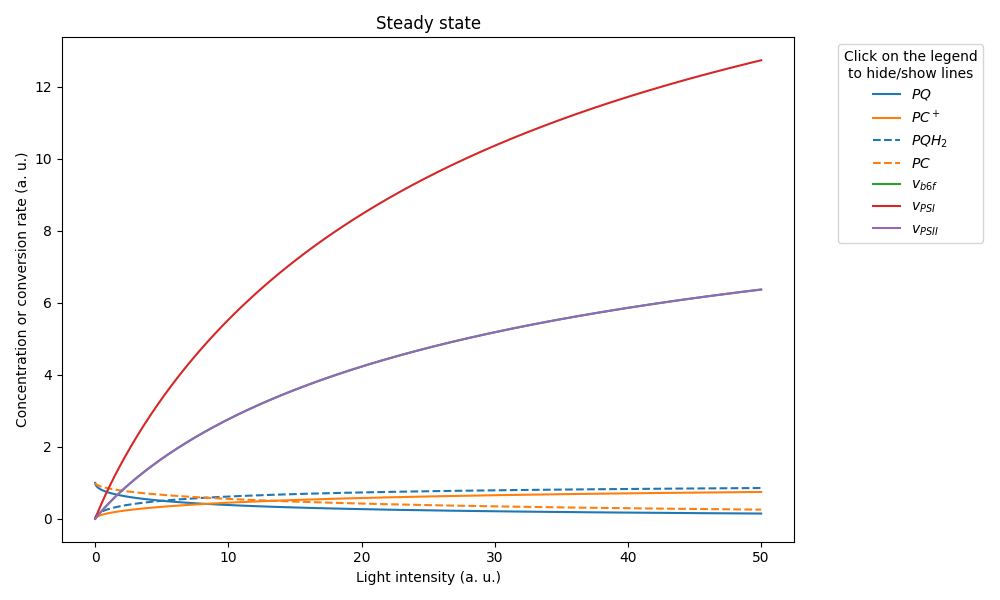

In [34]:
###### Run steady state simulation ######
 
I, C_PQ, C_PC_plus = run_steady_state()
C_PQH2, C_PC, v_b6f, v_PSI, v_PSII = get_dependent_variables(C_PQ, C_PC_plus, I)

###### Plot ######
 
fig, ax = plt.subplots(figsize=(10, 6))
C_PQ_line, = ax.plot(I, C_PQ, label='$PQ$', color = f"C{0}")
C_PC_plus_line, = ax.plot(I, C_PC_plus, label='$PC^+$', color = f"C{1}")
C_PQH2_line, = ax.plot(I, C_PQH2, '--', label='$PQH_2$', color = f"C{0}")
C_PC_line, = ax.plot(I, C_PC, '--', label='$PC$', color = f"C{1}")
v_b6f_line, = ax.plot(I, v_b6f, label='$v_{b6f}$', color = f"C{2}")
v_PSI_line, = ax.plot(I, v_PSI, label='$v_{PSI}$', color = f"C{3}")
v_PSII_line, = ax.plot(I, v_PSII, label='$v_{PSII}$', color = f"C{4}")

legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Click on the legend\nto hide/show lines')
legend.get_title().set_ha("center")

legend_lines = legend.get_lines()
lines = [C_PQ_line, C_PC_plus_line, C_PQH2_line, C_PC_line, v_b6f_line, v_PSI_line, v_PSII_line]
graphs = {}


for i, leg_line in enumerate(legend_lines):
    leg_line.set_picker(True)
    leg_line.set_pickradius(10)
    graphs[leg_line] = lines[i]
    
plt.connect('pick_event', on_pick)

ax.set_xlabel('Light intensity (a. u.)')
ax.set_ylabel('Concentration or conversion rate (a. u.)')
ax.set_title('Steady state')

fig.tight_layout() 

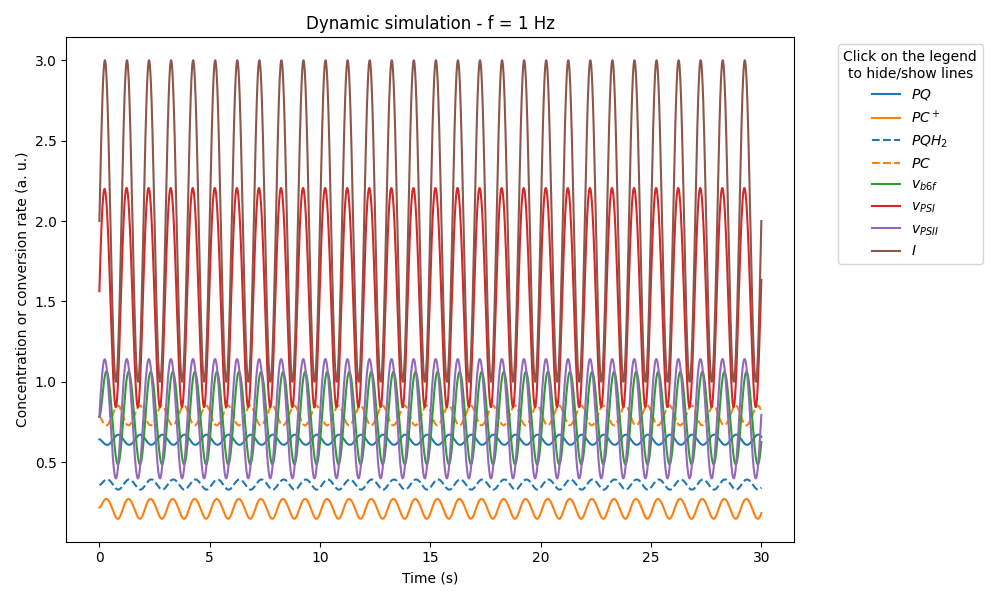

In [37]:
###### Run dynamic simulation ######

'''
The initial conditions for the dynamic simulation are the steady state values for the offser light intensity

'''

frequency = 1 # Hz
offset = 2 
amplitude = 1

t, I, C_PQ, C_PC_plus = run_dynamic(offset, amplitude, frequency)
C_PQH2, C_PC, v_b6f, v_PSI, v_PSII = get_dependent_variables(C_PQ, C_PC_plus, I)

###### Plot ######

fig, ax = plt.subplots(figsize=(10, 6))
C_PQ_line, = ax.plot(t, C_PQ, label='$PQ$', color = f"C{0}")
C_PC_plus_line, = ax.plot(t, C_PC_plus, label='$PC^+$', color = f"C{1}")
C_PQH2_line, = ax.plot(t, C_PQH2, '--', label='$PQH_2$', color = f"C{0}")
C_PC_line, = ax.plot(t, C_PC, '--', label='$PC$', color = f"C{1}")
v_b6f_line, = ax.plot(t, v_b6f, label='$v_{b6f}$', color = f"C{2}")
v_PSI_line, = ax.plot(t, v_PSI, label='$v_{PSI}$', color = f"C{3}")
v_PSII_line, = ax.plot(t, v_PSII, label='$v_{PSII}$', color = f"C{4}")
I_line, = ax.plot(t, I, label='$I$', color = f"C{5}")

legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Click on the legend\nto hide/show lines')
legend.get_title().set_ha("center")

legend_lines = legend.get_lines()
lines = [C_PQ_line, C_PC_plus_line, C_PQH2_line, C_PC_line, v_b6f_line, v_PSI_line, v_PSII_line, I_line]
graphs = {}

for i, leg_line in enumerate(legend_lines):
    leg_line.set_picker(True)
    leg_line.set_pickradius(10)
    graphs[leg_line] = lines[i]
    
plt.connect('pick_event', on_pick)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration or conversion rate (a. u.)')
ax.set_title(f'Dynamic simulation - f = {frequency} Hz')
fig.tight_layout()




In [27]:
######## Frequency response ########

bode_times, bode_PQ, bode_PC_plus, frequencies = run_frequency_response(offset, amplitude)

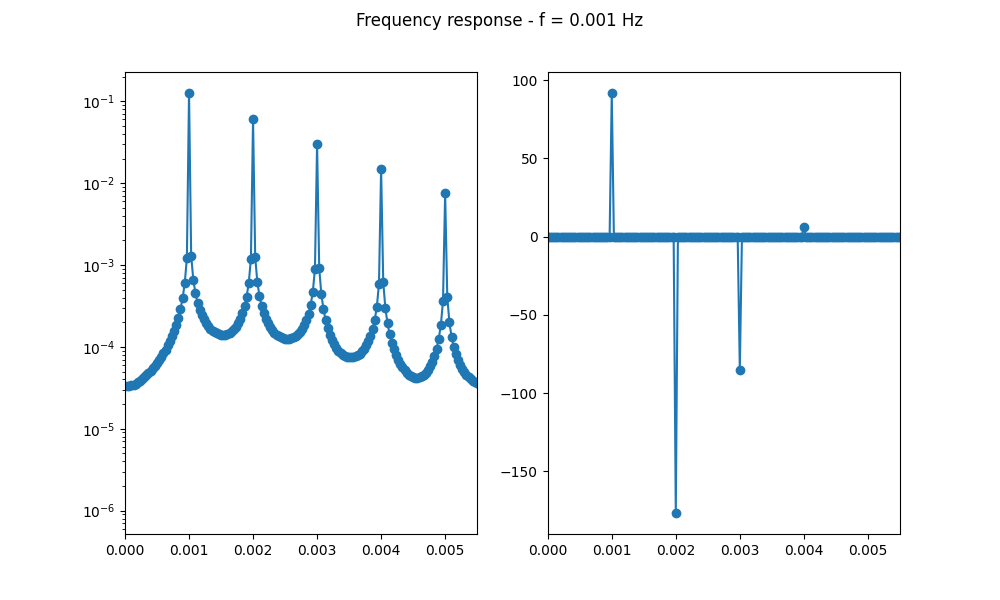

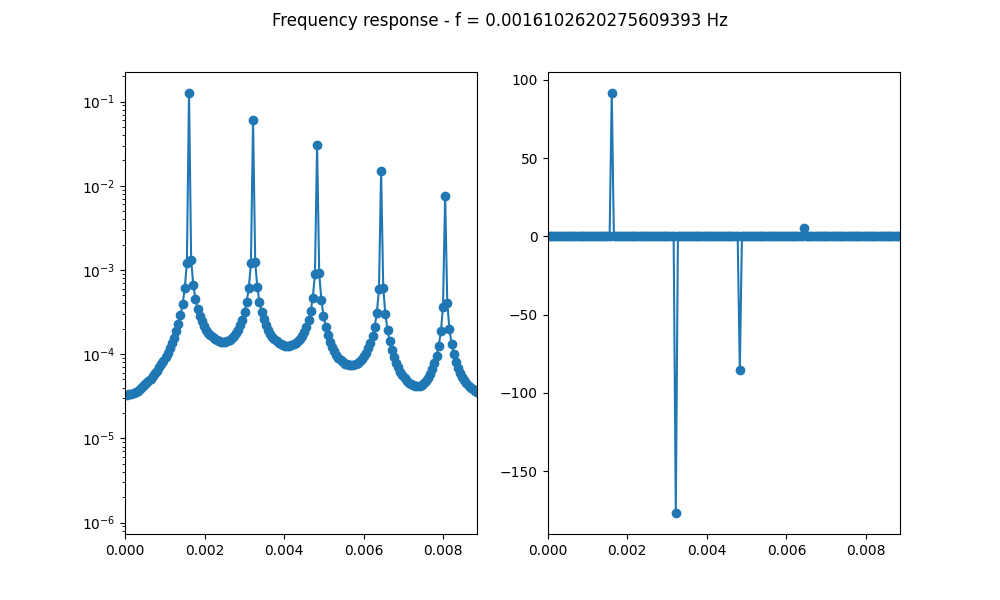

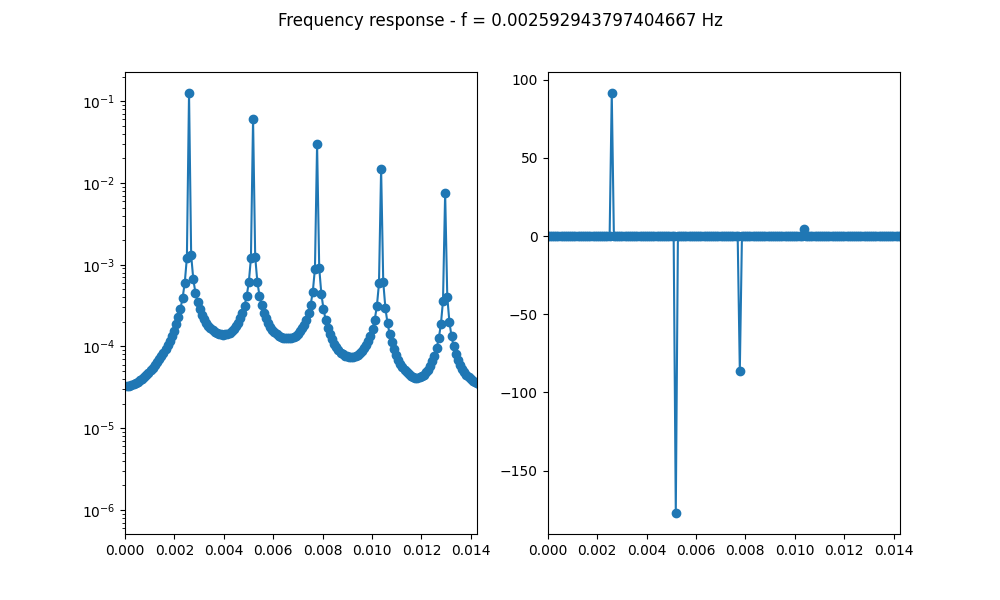

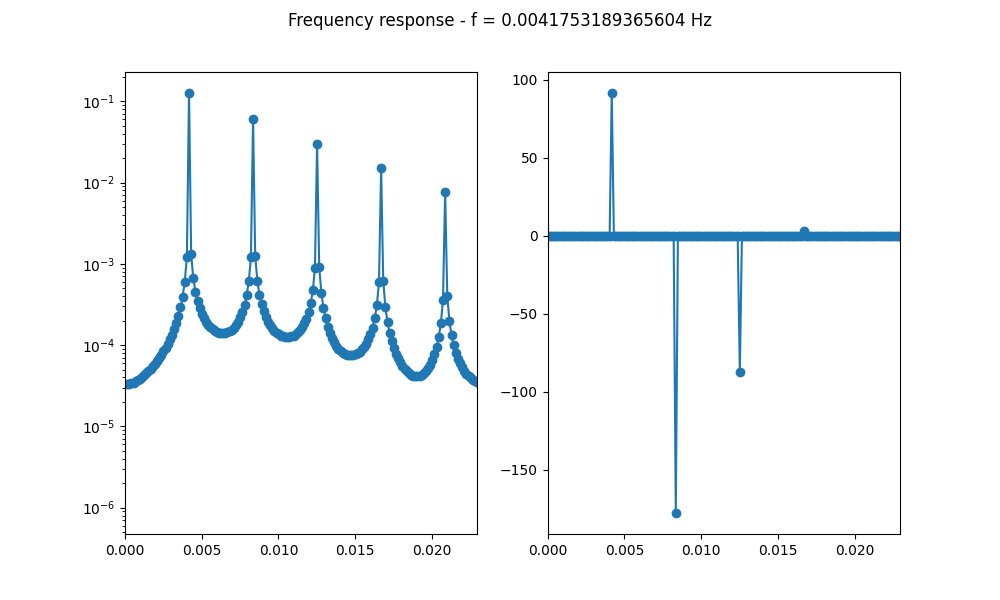

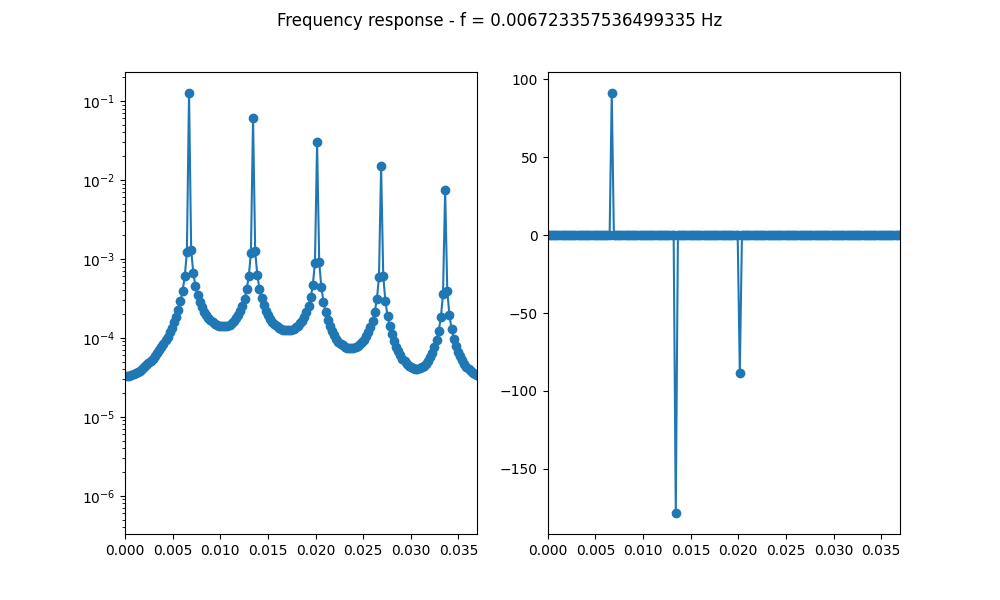

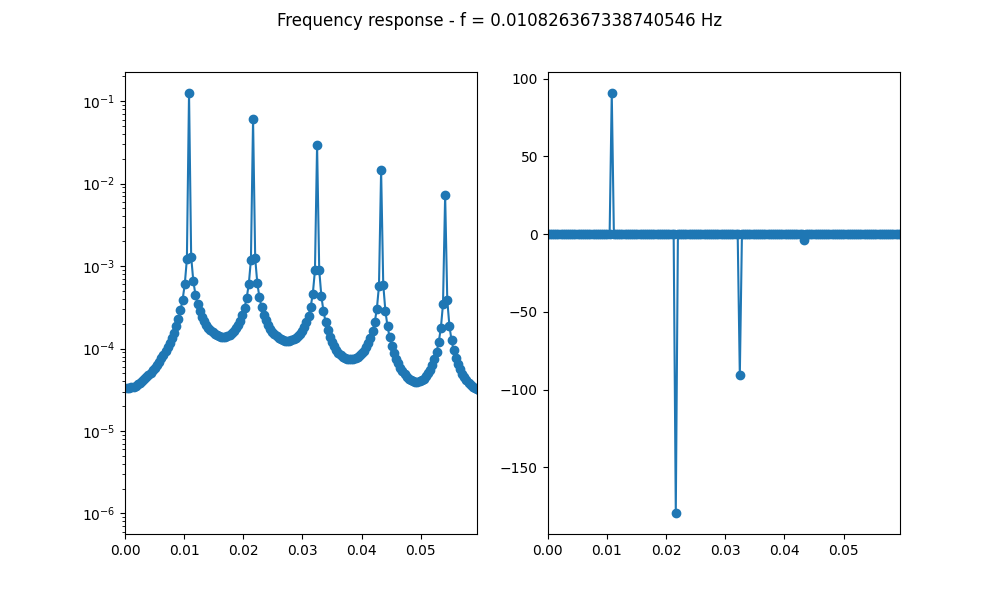

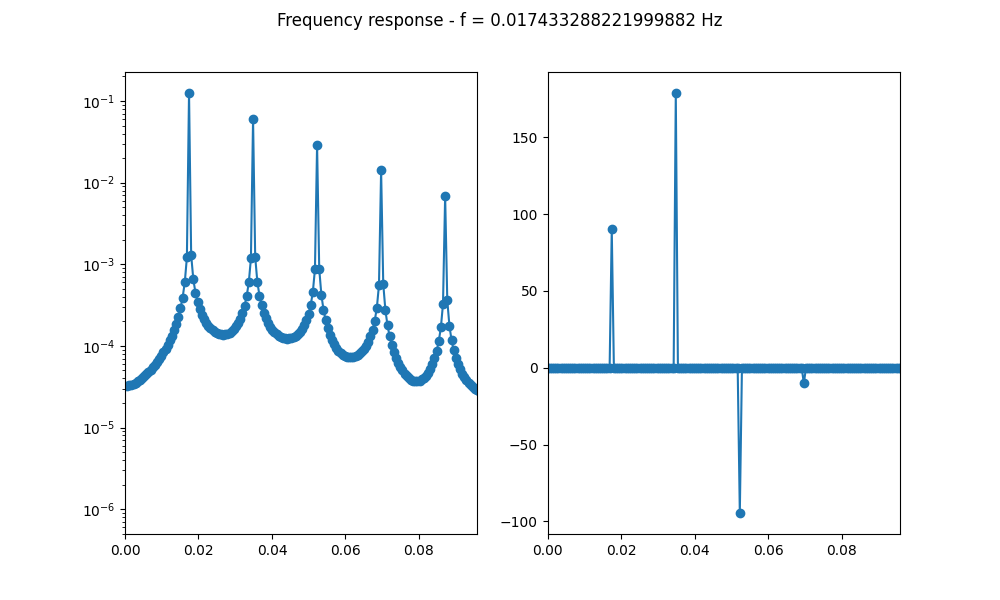

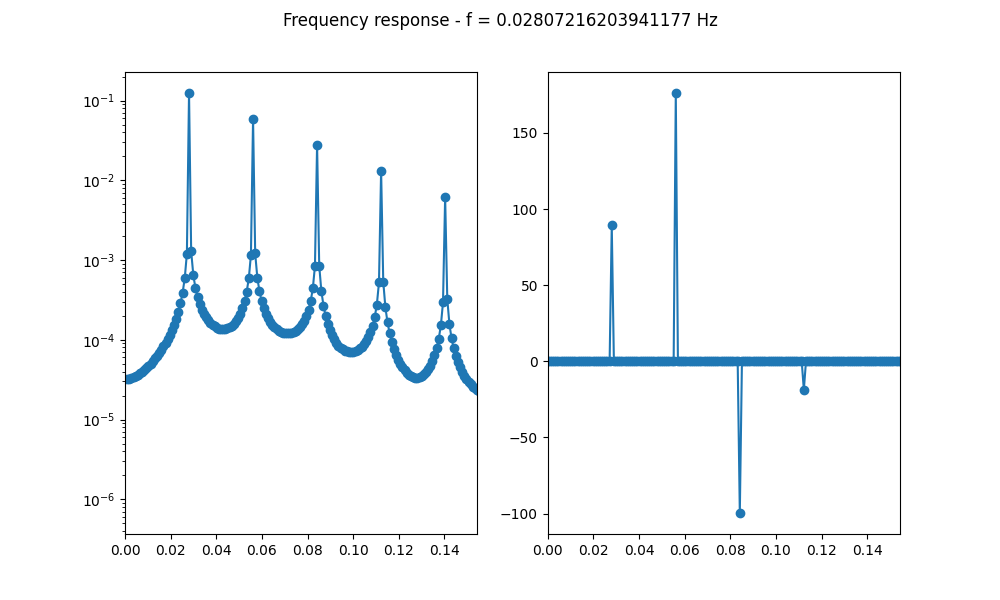

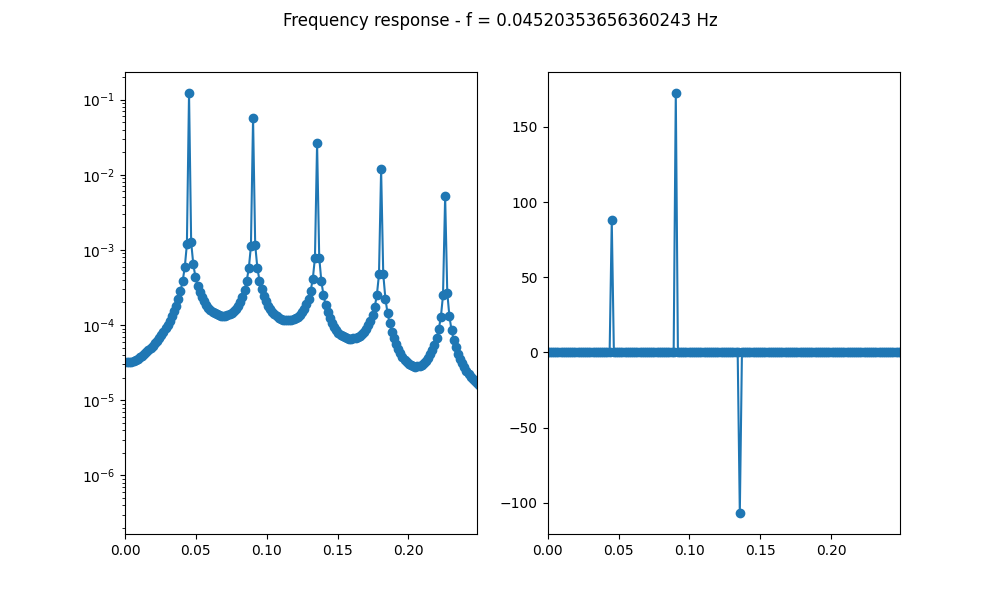

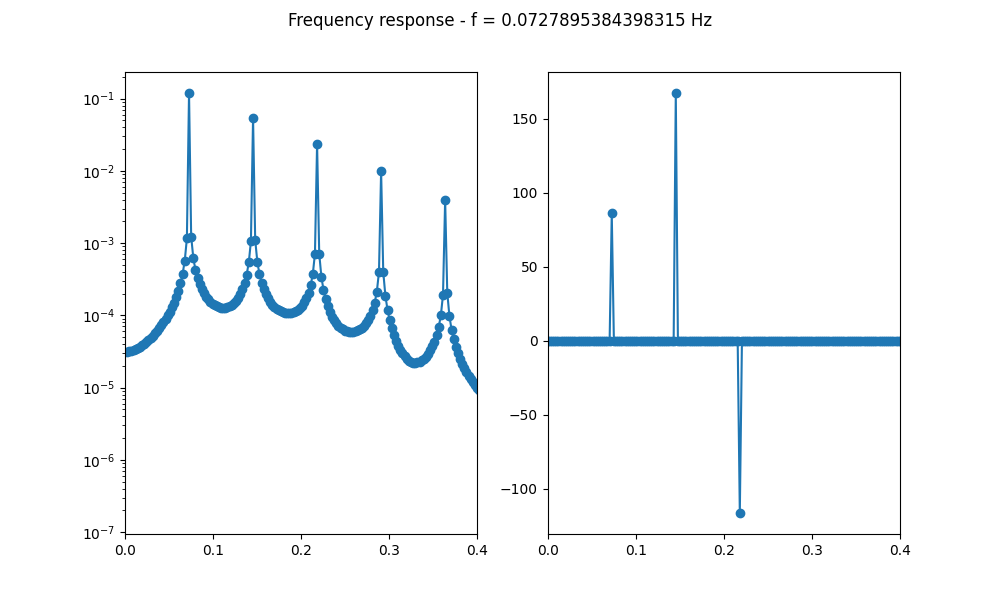

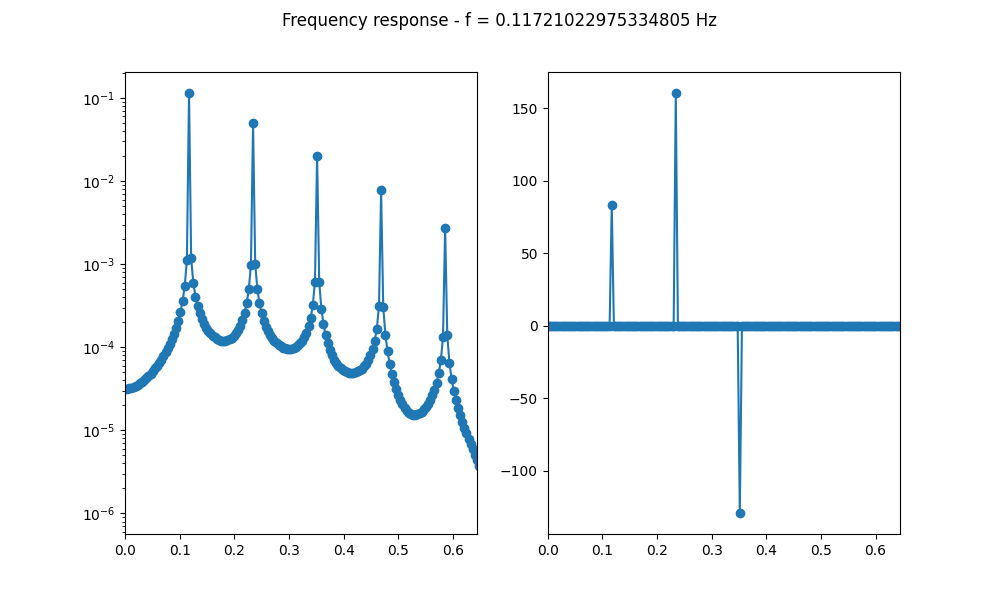

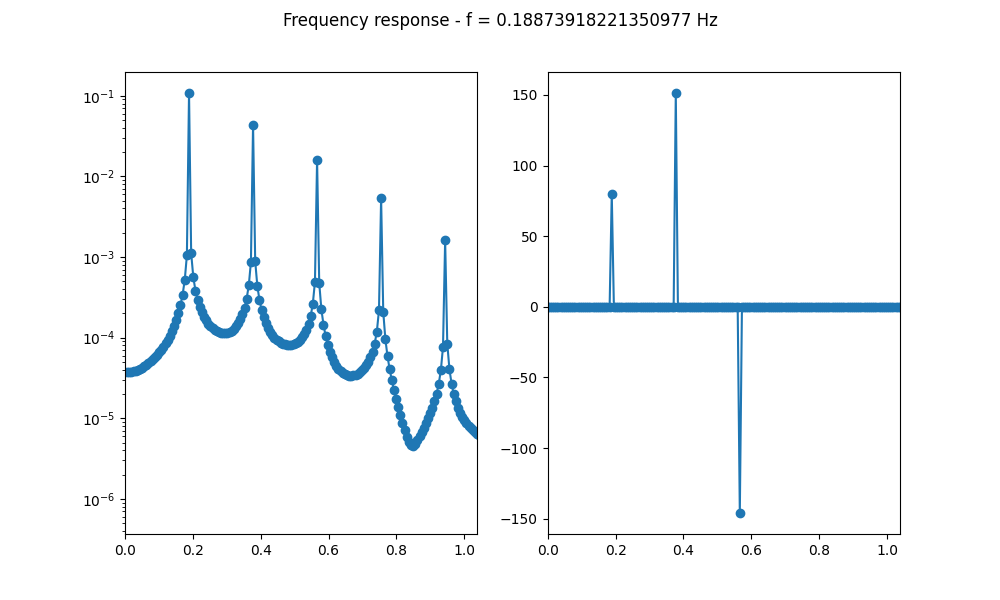

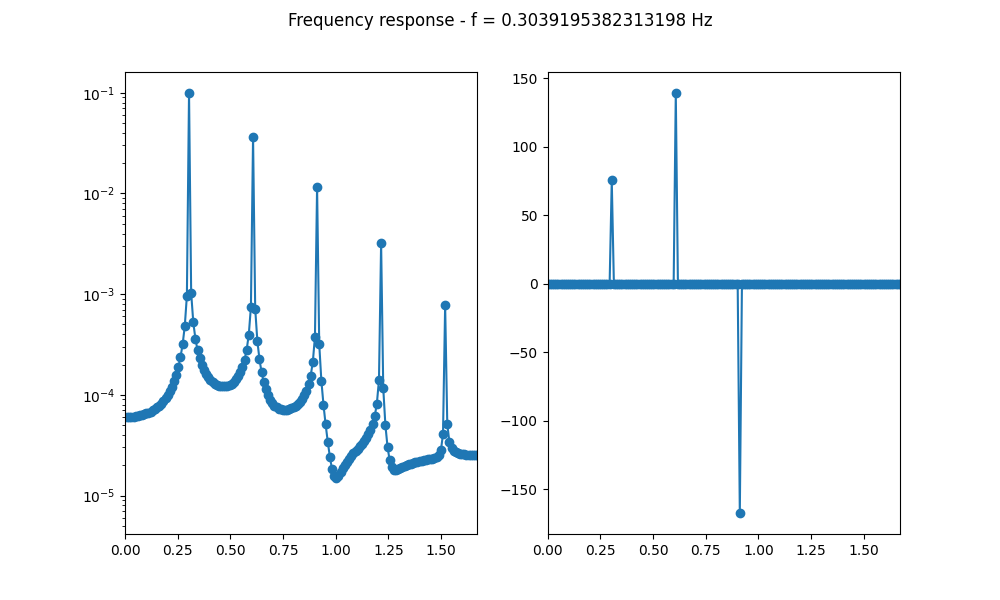

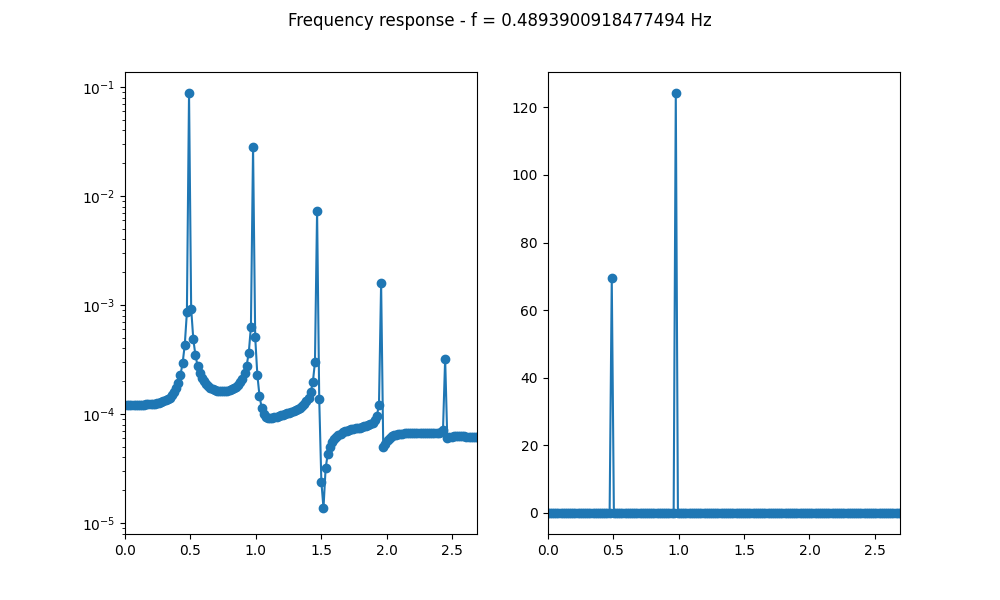

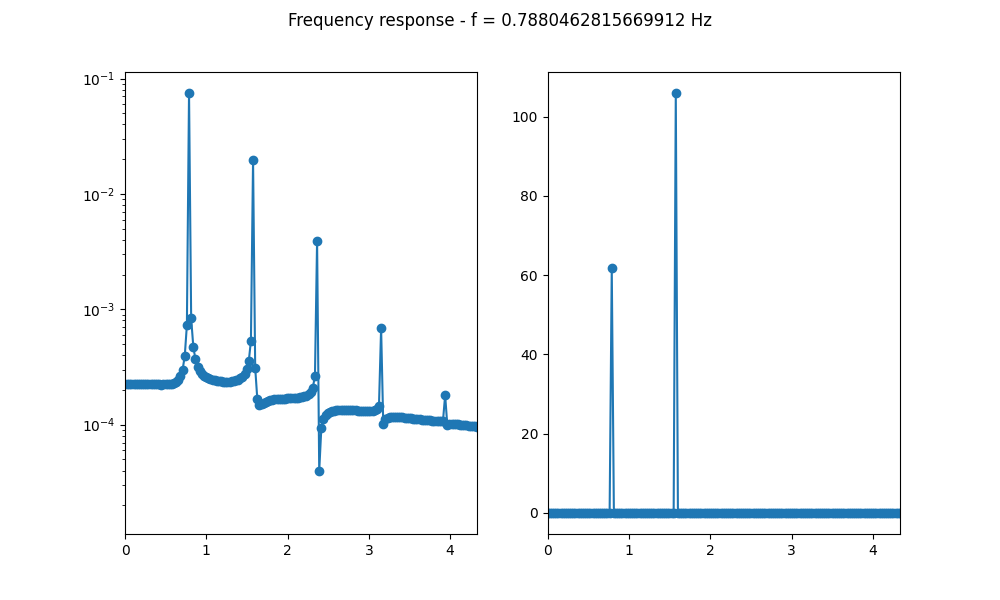

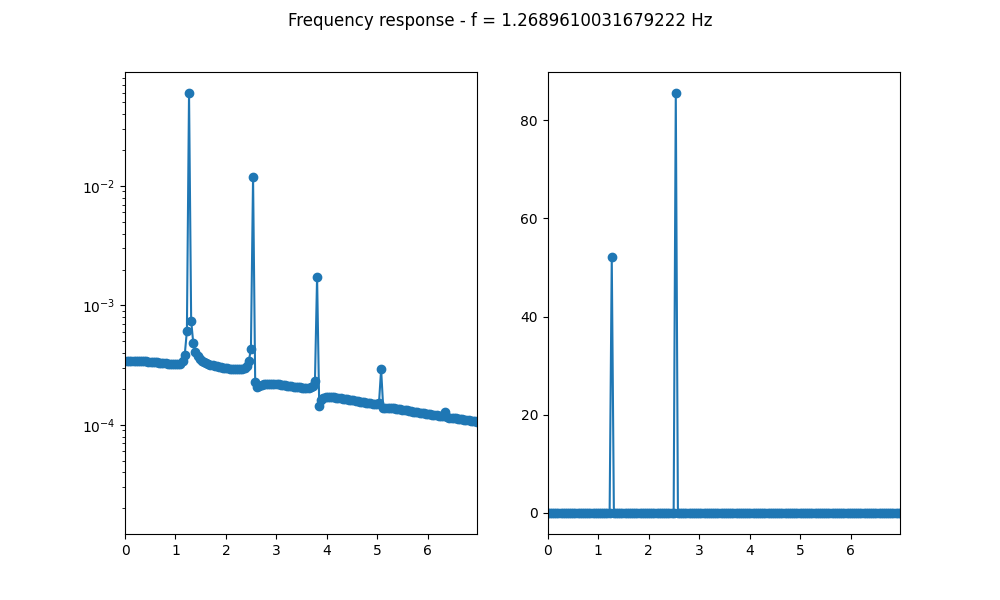

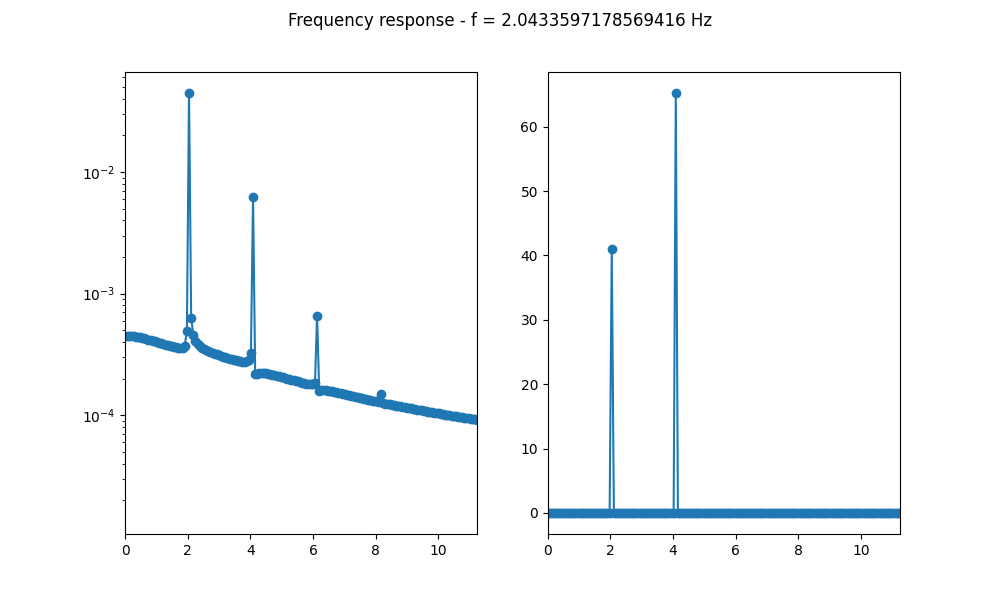

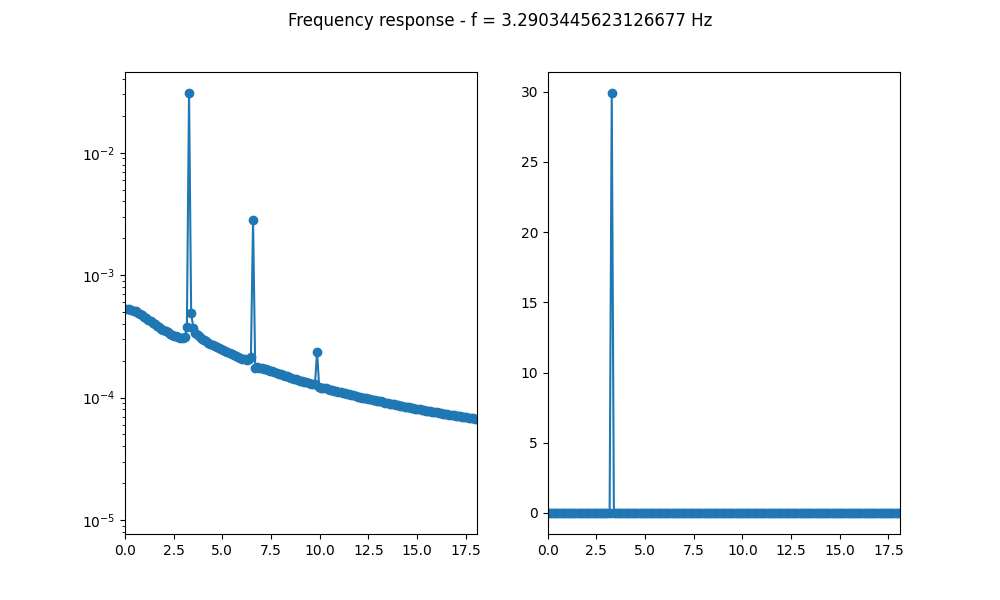

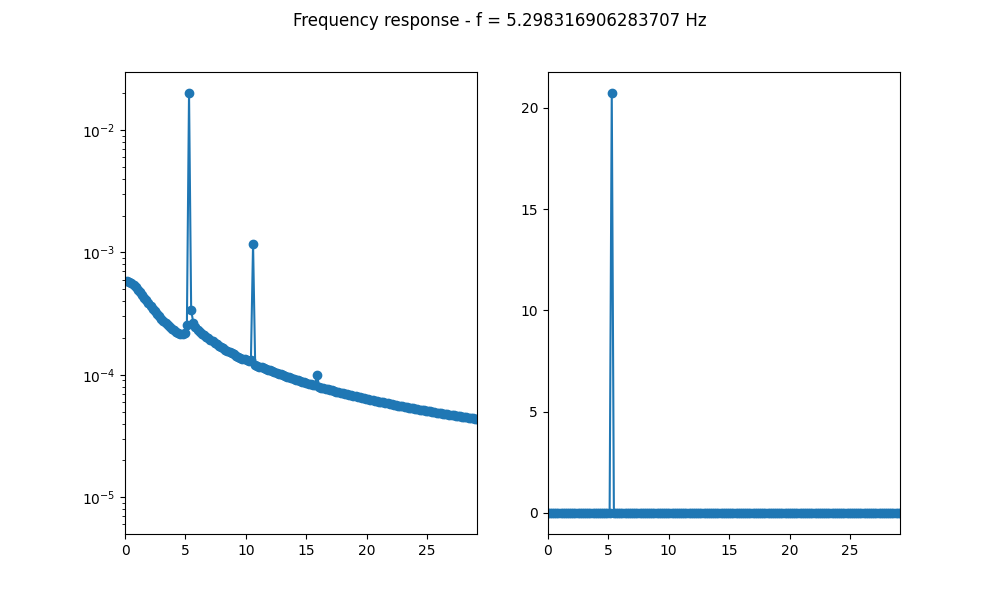

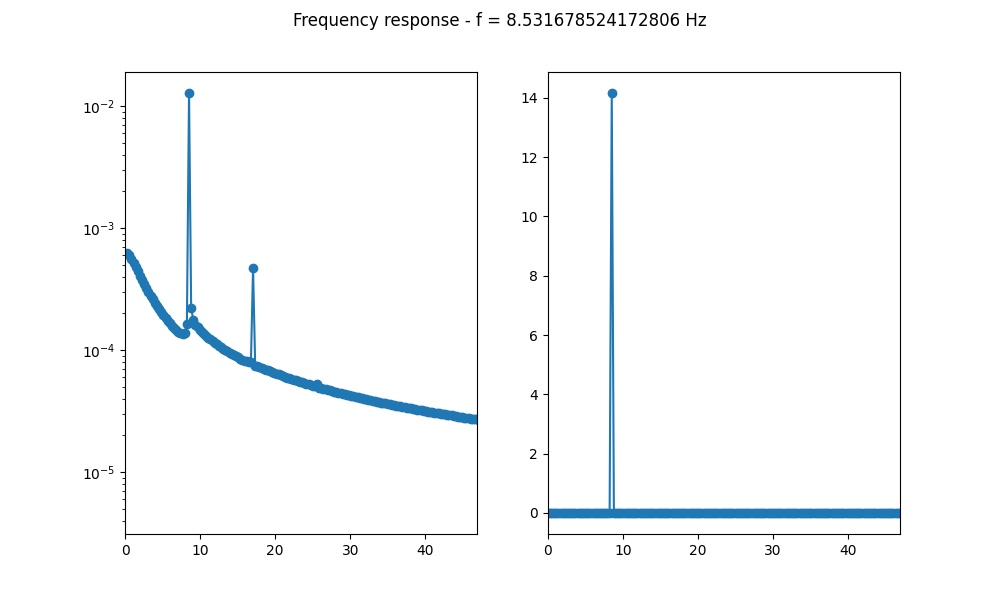

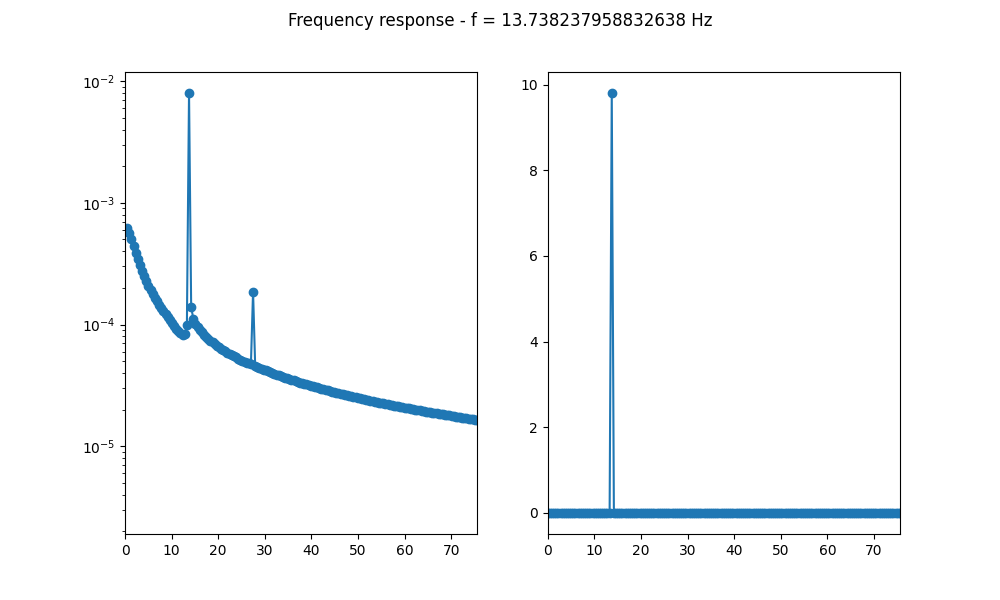

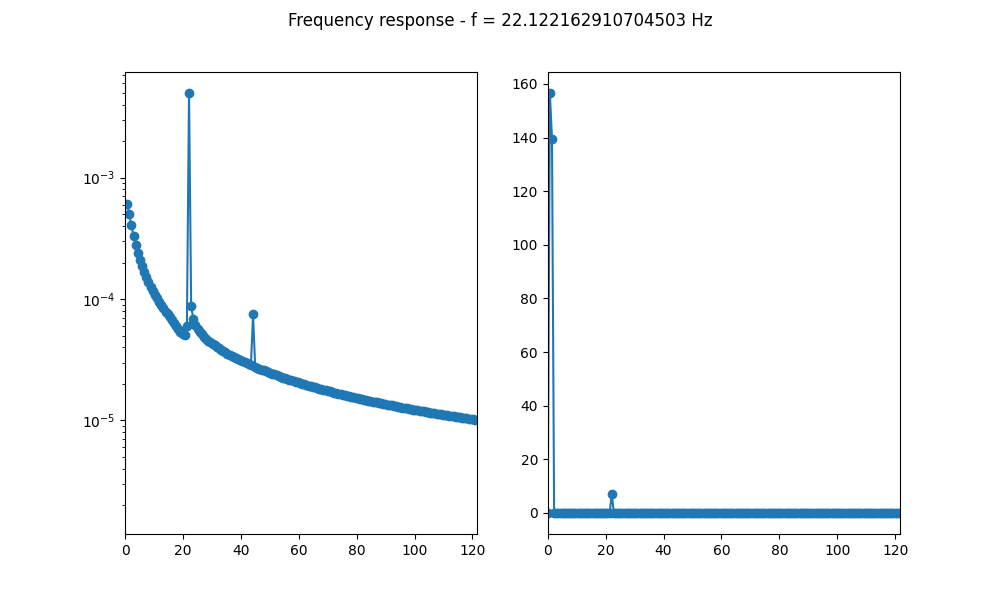

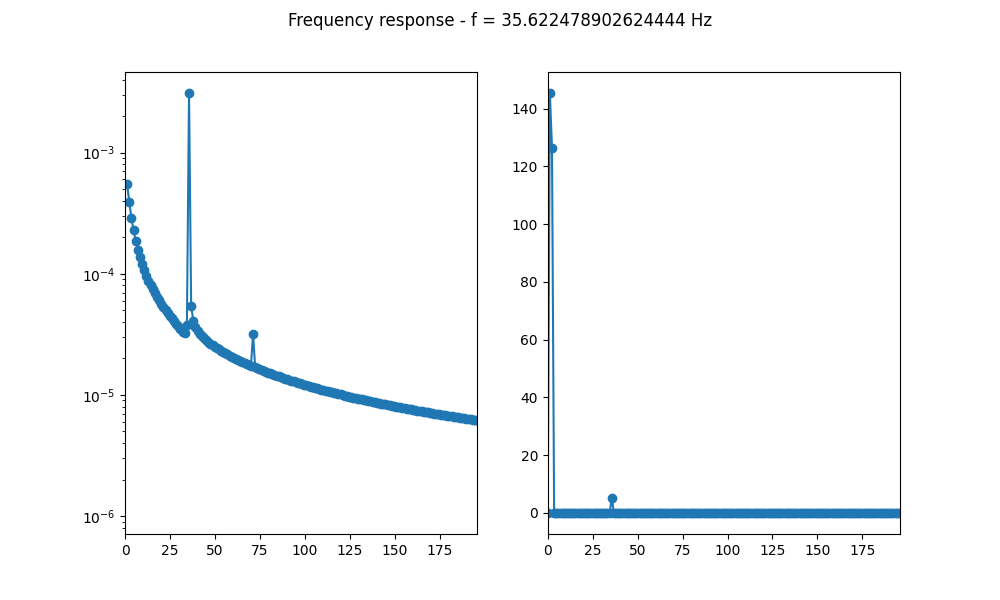

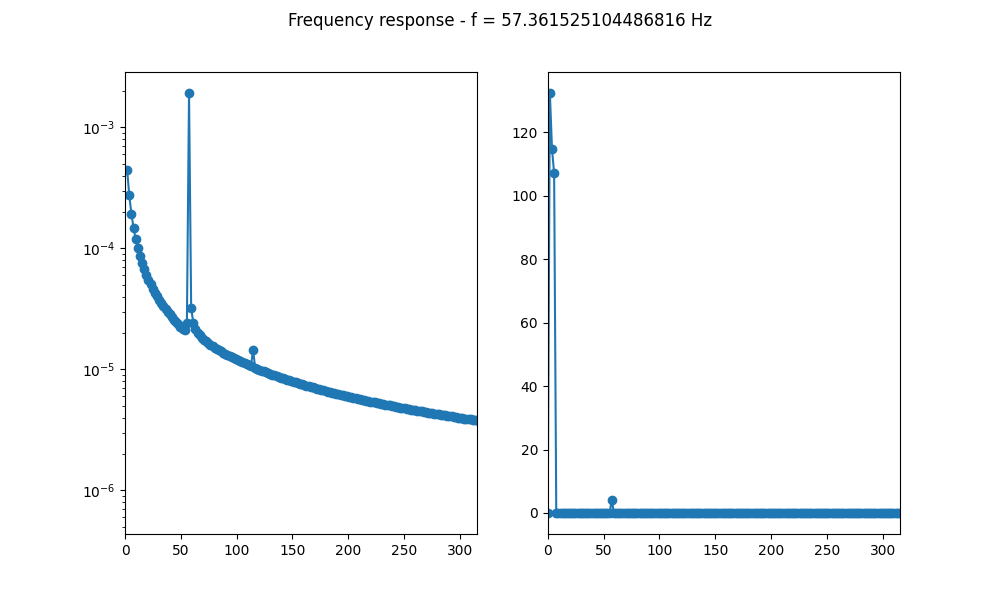

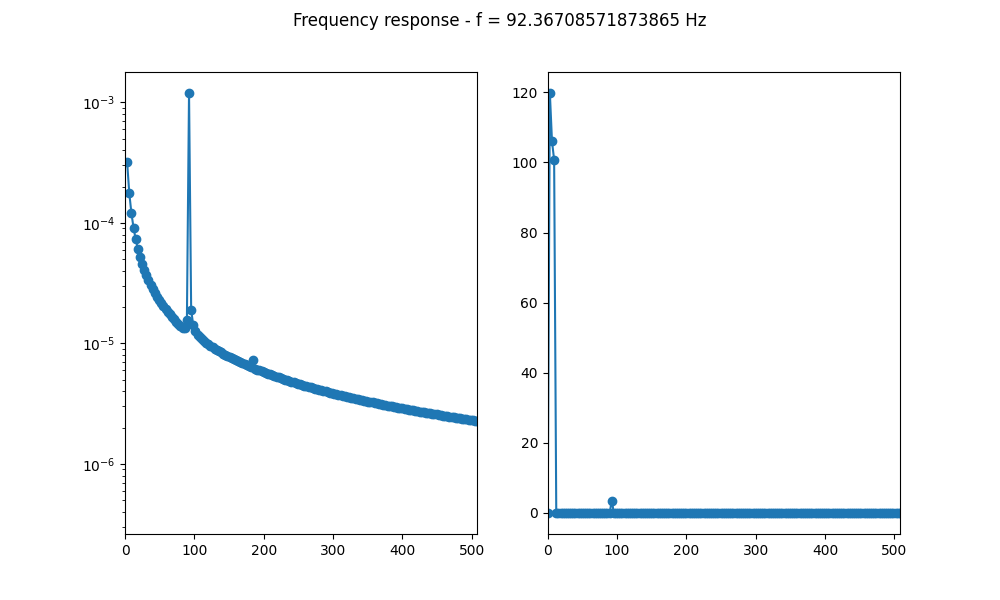

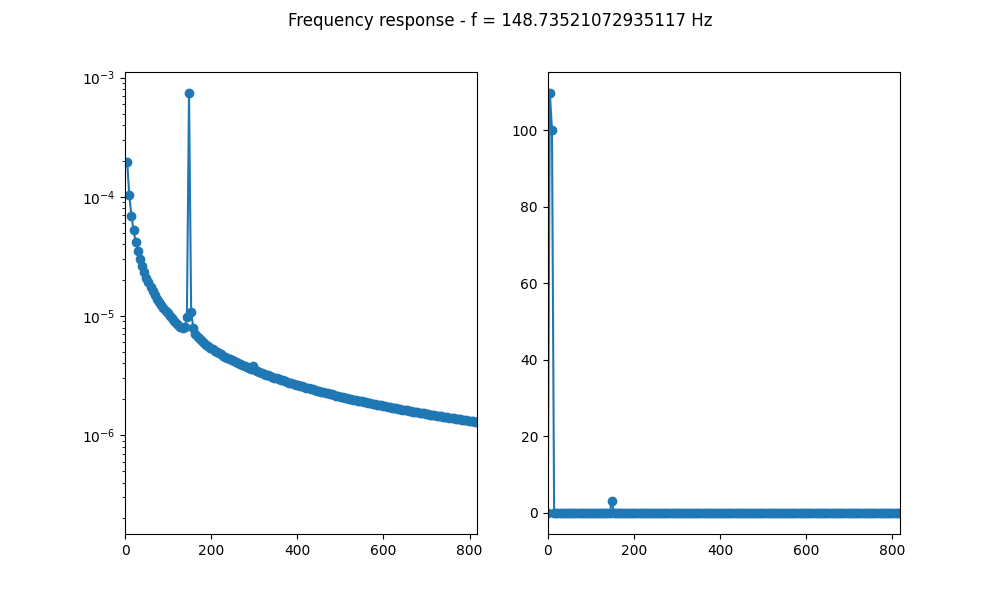

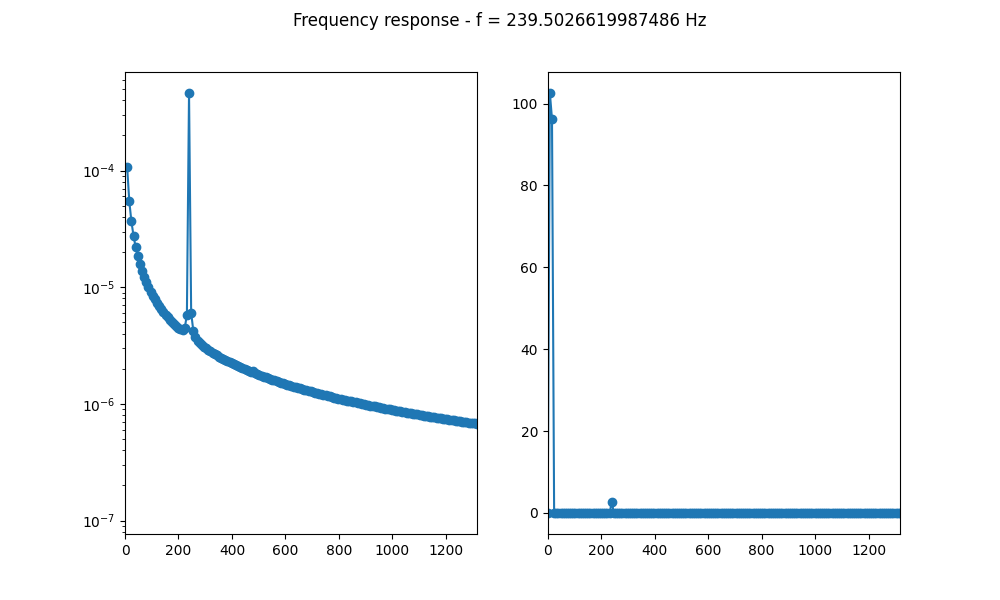

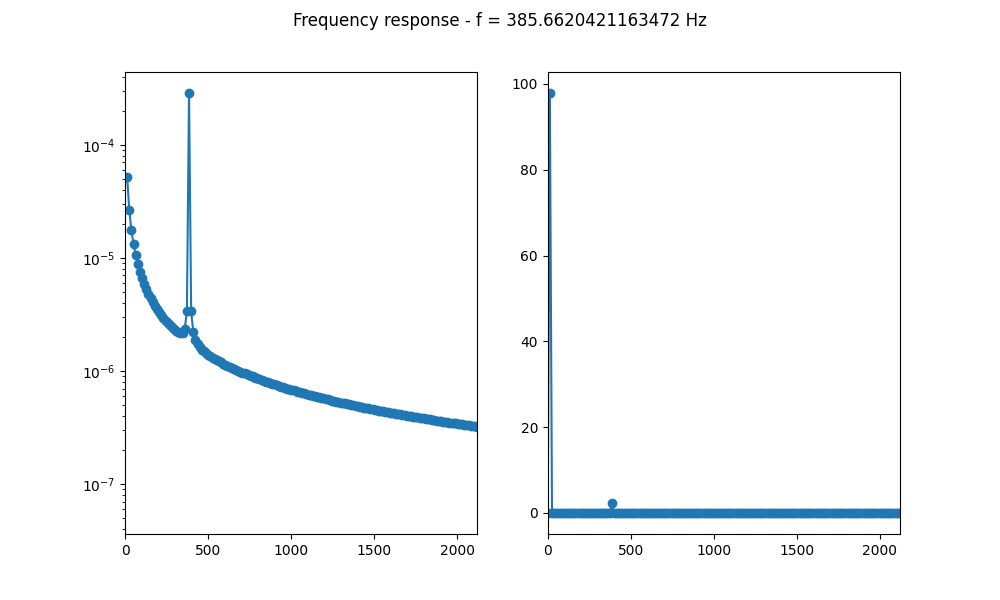

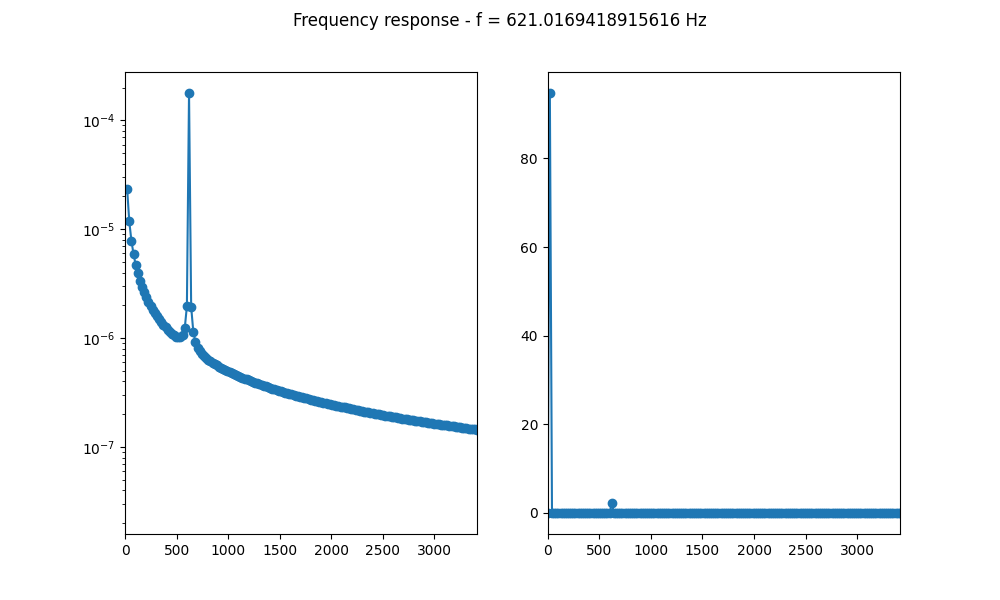

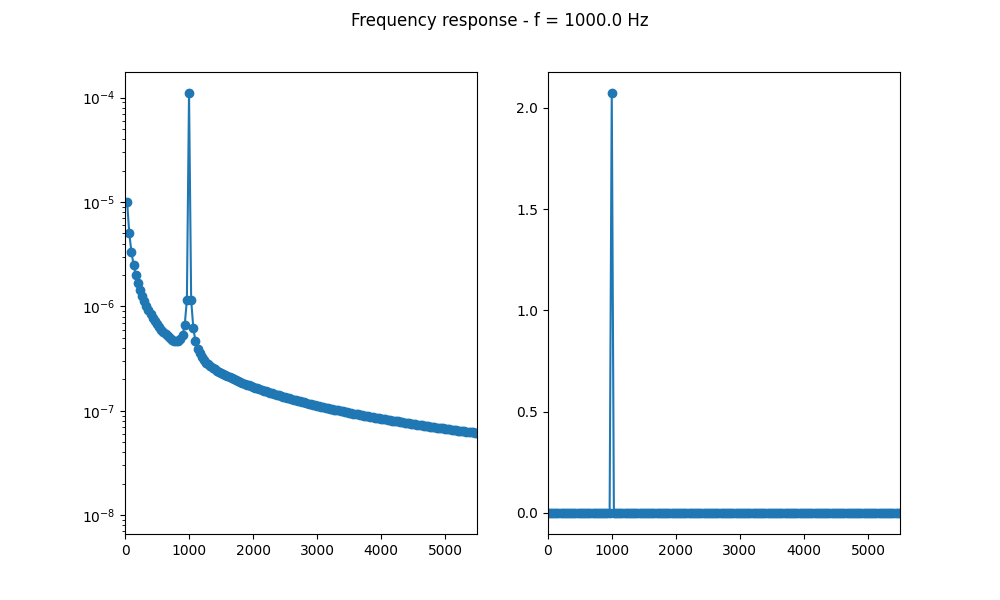

In [28]:
signal = []
detrend = []    
fft_freq = []
fft_amp = []
fft_phase = []
harmonics = pd.DataFrame()

plot = False

for i, freq in enumerate(frequencies):
    F, A, P = tools.FFT(bode_times[i], bode_PQ[i] - np.mean(bode_PQ[i]))
    fft_freq.append(F)
    fft_amp.append(A)
    fft_phase.append(P)
    fft_phase[i] = [phase if amplitude >= max(fft_amp[i])/phase_threshold else 0.0 for amplitude, phase in zip(fft_amp[i], fft_phase[i])]
    harmonics = pd.concat([harmonics, get_harmonics(freq, fft_freq[i], fft_amp[i], fft_phase[i], 3, 2)])
    
    
    if True:
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        ax[0].semilogy(fft_freq[i][1:],fft_amp[i][1:], '-o')
        ax[1].plot(fft_freq[i],fft_phase[i], '-o')
        ax[0].set_xlim(0, 5.5*freq)
        ax[1].set_xlim(0, 5.5*freq)
        fig.suptitle(f'Frequency response - f = {freq} Hz')

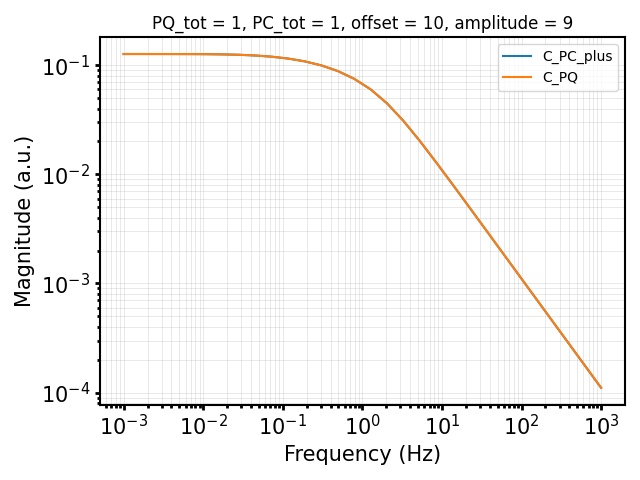

In [29]:
fig, ax = plt.subplots()
ax.plot(harmonics[f"f_input"], harmonics[f"A_0"], label = 'C_PC_plus')
ax.plot(harmonics[f"f_input"], harmonics[f"A_0"], label = 'C_PQ')
ax = tools.bode_plot_axes(ax)
ax.set_title(f'PQ_tot = {PQ_tot}, PC_tot = {PC_tot}, offset = {offset}, amplitude = {amplitude}')
ax.legend()
fig.tight_layout()

